# Visualizing the Ovation PRIME Aurora Forecast
The following notebook shows the various exploratory steps in creating a series of hooks for Python regarding live space weather data that is made available by the [National Oceanic and Atmospheric Administration](http://www.swpc.noaa.gov/).

### Ovation Aurora Short Term Forecast
To start with, we will be investigating theaurora borealis forecast produced by the OVATION Prime model, available at the Space Weather Prediction Center. We'll be ingesting the NOAA data (text file), and saving as a [pandas](http://pandas.pydata.org/) array, along with forecast timestamp to encode as the filename of our newly created image.

Link: http://services.swpc.noaa.gov/text/aurora-nowcast-map.txt

On the website, service looks like:
<table>
    <tr>
        <th>Northern Hemisphere</th>
        <th>Southern Hemisphere</th>
    </tr>
    <tr>
        <td><img src="http://services.swpc.noaa.gov/images/aurora-forecast-northern-hemisphere.jpg" width=300></td>
        <td><img src="http://services.swpc.noaa.gov/images/aurora-forecast-southern-hemisphere.jpg" width=300></td>
    </tr>
</table>

## Background
This notebook was built using the latest (as of writing) [Anaconda3 distribution](https://www.continuum.io/downloads) from Continuum Analytics. It is free of charge, and is set up by default to be run by a single Windows user, bypassing the need for complex installation methods. It is slowly becoming the standard distribution for scientific Python use cases, as it:

1. comes with many batteries included (scientific packages including *numpy*, *matplotlib*, *scipy*, *pandas*, etc.), and
2. comes with its own package manager, *conda*, similar to pip, but ships binaries that are tested on all major platforms.
3. runs on all major platforms: Linux, macOS and Windows.

In [1]:
import sys
print(sys.version)

3.6.0 |Anaconda custom (64-bit)| (default, Dec 23 2016, 11:57:41) [MSC v.1900 64 bit (AMD64)]


## Data input
First, we check if we can connect to the web, then grab and parse the data:

In [2]:
from datetime import datetime
from io import StringIO
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests

# Will need to fix the connection to get the update every n minutes,
# but for now devputer can't connect to the Internet.
aurora_url = 'http://services.swpc.noaa.gov/text/aurora-nowcast-map.txt'
aurora_file = 'aurora-nowcast-map.txt'

def internet_is_up(host="8.8.8.8", port=53, timeout=3):
    """
    Host: 8.8.8.8 (google-public-dns-a.google.com)
    OpenPort: 53/tcp
    Service: domain (DNS/TCP)
    """
    import socket
    try:
        socket.setdefaulttimeout(timeout)
        socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect((host, port))
        return True
    except Exception as ex:
        return False

def get_forecast(url, fallback):
    """Retrieves the array file for global forecasts from the swpc.noaa site.
    These are given in plate carrée.
    If Internet is down, retrieves local copy. Needs no args.    
    
    Extent:
    1024 values covering 0 to 360 degrees in longitude (0.32846715 deg/px)
    512 values covering -90 to 90 degrees in latitude (0.3515625 deg/px)
    
    Returns:
    array: pandas array of the forecast
    datetime: date & time of forecast
    
    None -> np.array, datetime"""
    
    extent = (-180, 180, -90, 90)
    timestamp = None
    
    # Having problems with local proxy, using local copy instead.
    # [ ] FIXME: Proxy connection issues
    """
    def file_modified(filename):
        t = os.path.getmtime(filename)
        t = datetime.fromtimestamp(t)
        elapsed_time = datetime.now() - t
        return elapsed_time.total_seconds()
    """
    
    # Download dataset
    if internet_is_up():
        file = requests.get(url, headers=headers)
        output = open(file, 'wb')
        output.write(file.content)
        output.close()
    else:
        file = fallback
        
    # Get timestamp
    timestamp = None
    with open(file) as f:
        for line in f:
            if line.startswith('# Product Valid At:'):
                timestamp = datetime.strptime(line[-17:-1], '%Y-%m-%d %H:%M')

    # Get data grid
    # [ ] TODO: find a way to only open file once.
    array = pd.read_csv(file, comment='#', delimiter='\s+', header=None)
    return array, timestamp


# Low-tech unit testing. If Python doesn't yell, we're good.
_array, _timestamp = get_forecast(url=aurora_url, fallback=aurora_file)
assert _array.shape == (512, 1024)
assert str(_timestamp)[0:2] == '20'  # From '2017...'
print('Image ready')

Image ready


## Visualization
### Equirectangular Projection (Plate Carrée)
We'll start off with a basic matplotlib figure, where each pixel in the data file represents approximately a third of a degree. The figure below, however, has been expanded a bit, with bicubic interpolation to smooth the values between the dots. With proper transparency, this could be overlaid on top of the base map in Google Earth.

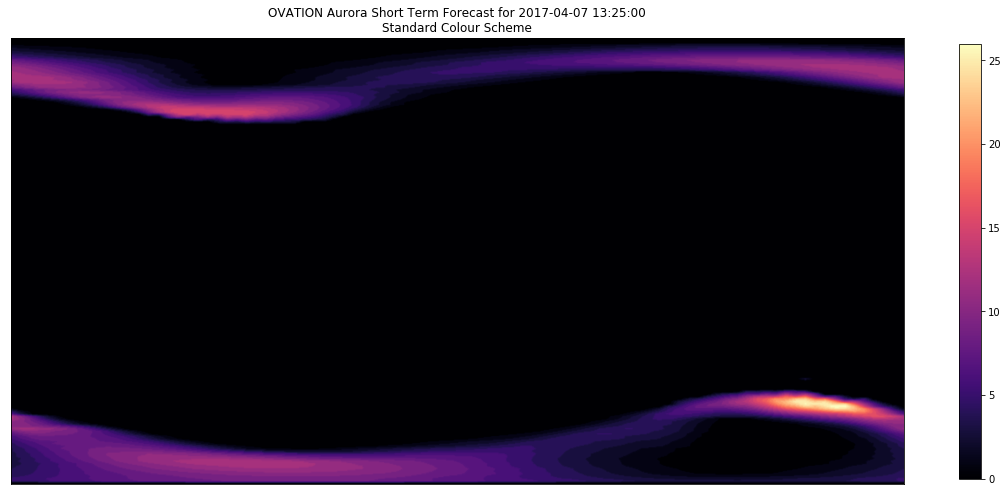

In [3]:
plt.figure(figsize=(20, 20))
plt.imshow(_array, 
           interpolation='bicubic',
           cmap='magma',
           origin='lower',
          )
plt.colorbar(shrink=0.4)
plt.title('OVATION Aurora Short Term Forecast for {}\nStandard Colour Scheme'.format(_timestamp))
plt.xticks([]), plt.yticks([])
plt.show()

### Transparency
That's great, but what really need is an extra transparency channel to our visualization. For that, we'll need to define our own matplotlib color map, which is [explained here](http://matplotlib.org/examples/pylab_examples/custom_cmap.html).

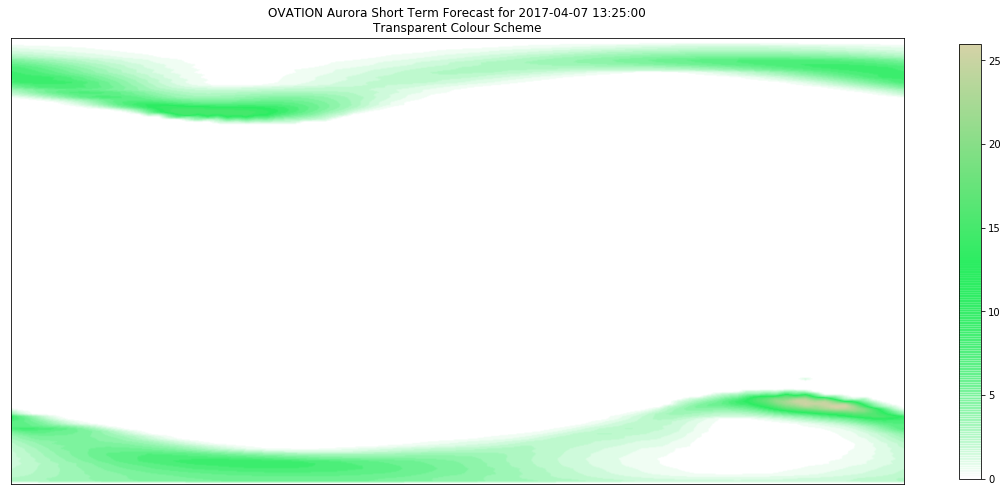

In [4]:
def aurora_cmap():
    """Return a colormap with aurora-like colors
    and transparency."""
    from matplotlib.colors import LinearSegmentedColormap
    stops = {'red': [(0.00, 0.1725, 0.1725),
                     (0.50, 0.1725, 0.1725),
                     (1.00, 0.8353, 0.8353)],

             'green': [(0.00, 0.9294, 0.9294),
                       (0.50, 0.9294, 0.9294),
                       (1.00, 0.8235, 0.8235)],

             'blue': [(0.00, 0.3843, 0.3843),
                      (0.50, 0.3843, 0.3843),
                      (1.00, 0.6549, 0.6549)],

             'alpha': [(0.00, 0.0, 0.0),
                       (0.50, 1.0, 1.0),
                       (1.00, 1.0, 1.0)]}

    return LinearSegmentedColormap('aurora', stops)

plt.figure(figsize=(20, 20))
plt.imshow(_array, 
           interpolation='bicubic',
           cmap = aurora_cmap(),
           origin='lower',
          )
plt.colorbar(shrink=0.4)
plt.title('OVATION Aurora Short Term Forecast for {}\nTransparent Colour Scheme'.format(_timestamp))
plt.xticks([]), plt.yticks([])

plt.show()


### Exporting the transparent image
There are many different filetypes possible, but let's go with a simple png, which can handle transparency:

In [5]:
plt.figure(figsize=(50, 50),
           frameon=False)
plt.imshow(_array, 
           interpolation='bicubic',
           cmap = aurora_cmap(),
           origin='lower',
      )
plt.axis('off')
plt.xticks([]), plt.yticks([])
plt.savefig('ovation_test.png',
            transparent=True,
            bbox_inches='tight',
            pad_inches=-0.035)  # A little hacky, but gets rid of the invisible border

We can now input this as an overlay in Google Earth:

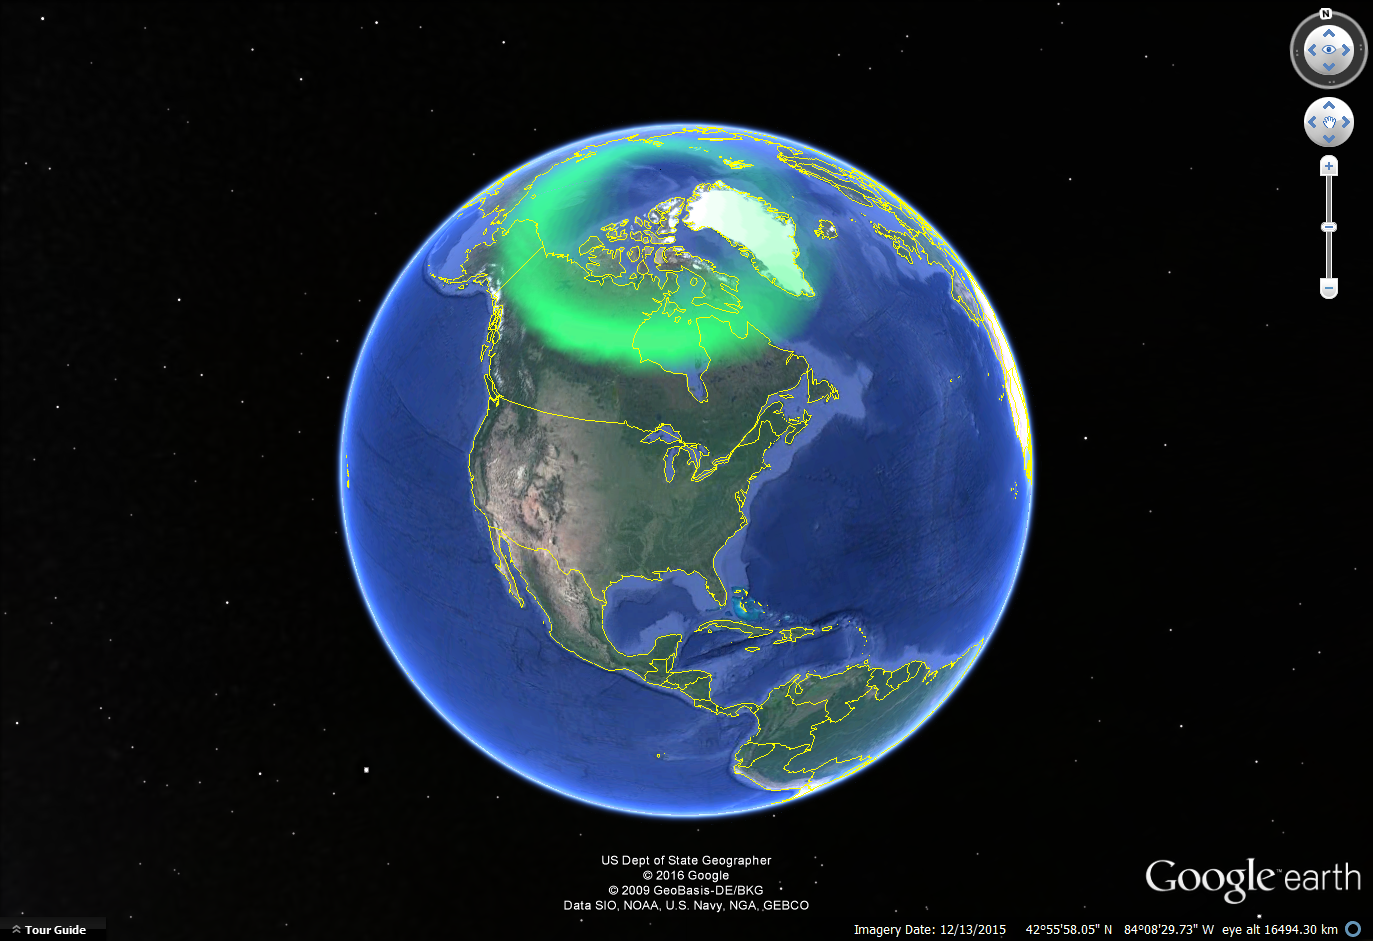

In [6]:
from IPython.core.display import Image
Image('GEarth overlay.png', retina=True)

## STK
The actual implementation for this is to overlay this image on top of the visualizations provided by the [STK software](https://en.wikipedia.org/wiki/Systems_Tool_Kit). The way STK is used unfortunately leads us to export as jpg and define the transparency through a convulated means. This is done by setting the top-left pixel as `(0, 0, 0)`:

In [7]:
# Override first pixel's value to zero to mark transparency in STK
_array[0, 0] = 0

FILENAME = 'ovation_{}.jpg'.format(_timestamp.strftime('%Y-%M-%d-%H-%M'))

plt.figure(figsize=(50, 50),
           frameon=False)
plt.imshow(_array, 
           interpolation='bicubic',
           cmap = aurora_cmap(),
           origin='lower')
plt.axis('off')
plt.xticks([]), plt.yticks([])
plt.savefig(FILENAME,
            transparent=True,
            bbox_inches='tight',
            pad_inches=-0.035)

# Low-tech unit test: won't print unless file exists
assert os.path.exists(FILENAME)
print('Image ready:', FILENAME)

Image ready: ovation_2017-25-07-13-25.jpg


Which renders as the following when overlaid  over the default map in STK:

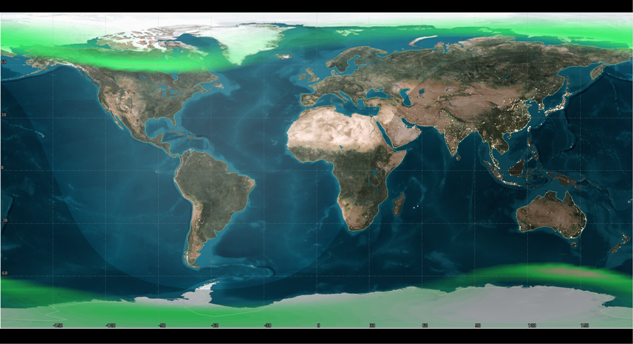

In [8]:
Image('stk_overlay.png')

## *Extra: Basemap*
For the sake of curiosity however, it is also interesting to explore how we can provide that visualization directly from the Python libraries. In fact,for this we can use the matplotlib ['contrib' module called Basemap](http://matplotlib.org/basemap/). It is an add-on to the plotting package which allows to work with geographical material.

Our data is provided as Plate Carrée, so we can use this to project the image onto the globe. 

As an aside, Basemap does not come pre-packaged with Anaconda3, so we install it with:

    $ conda install -c conda-forge basemap

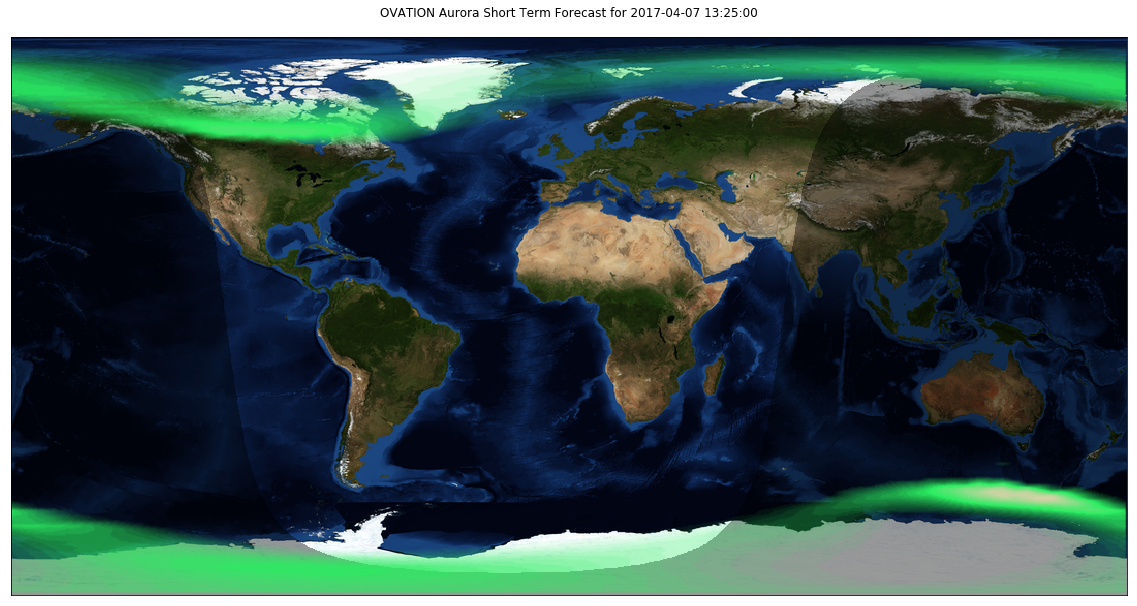

In [10]:
# The method call `map.imshow()` gets a deprecation warning in matplotlib 2,
# which we'll silence.
import warnings
warnings.filterwarnings('ignore')

from mpl_toolkits.basemap import Basemap
plt.close()
plt.figure(figsize=(20, 20))
map = Basemap(projection='cyl')
map.bluemarble(scale=0.2)
map.nightshade(date=_timestamp,
               alpha=0.4,
               zorder=1)
map.imshow(_array, 
           interpolation='bicubic',
           cmap = aurora_cmap(),
           origin='lower',
           zorder=2,)
plt.title('OVATION Aurora Short Term Forecast for {}\n'.format(_timestamp))
plt.show()